In [268]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pycatch22 as catch22
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.spatial import distance
import pickle
from sklearn.metrics import pairwise_distances
from scipy import stats
import sdeint
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')


## Epsilon

1. Simulate 200 TS from fixed point in parameter space for Hopf system. Let's try $\mu = -1$, $\eta = 0.1$. These TS are all similar in the dynamical systems sense, so their 'distance' in 'dynamical system space' is 0. 

In [253]:
np.random.seed(0)
mu = -1
eta = 0.5
num_samples = 200
sols_list = list()
dt = 0.01
tspan = np.arange(0, 55, dt)
def f(state, t):
    x, y = state[0], state[1]
    dxdt = -y + (mu - x **2 - y**2) * x
    dydt = x + (mu - x ** 2 - y **2) * y
    return dxdt, dydt
for i in range(num_samples):
    ic = np.array(np.random.uniform(size=2)) # uniform random initial conditions
    gw = lambda y, t: eta * np.identity(ic.shape[0]) # noise is relative to ic's 
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    sols_list.append(sol[500:]) # cut out first 500 time points

In [254]:
TS = np.array([sols_list[i][:,0] for i in range(len(sols_list))]) # extract x component
FEATURES_SAME = np.array([catch22.catch22_all(TS[i,:])['values'] for i in range(len(sols_list))])

Now lets look at TS that are 'close' in a dynamical systems sense. We will define close here to mean a 5% difference in the value of $\mu$ in either direction i.e. $\Delta \mu = 5\%$

In [255]:
np.random.seed(0)
eta = 0.5
num_samples = 200
mu_centre = np.tile(-1, 100) # centre value
mu_neg = np.tile(-1.05, 100) # delta mu is 5% in negative direction
mu_pos = np.tile(-0.95, 100) # delta mu is 5% in positive direction
mus = np.concatenate((mu_neg, mu_centre, mu_pos)) # NOTE ORDER 
sols_list = list()
dt = 0.01
tspan = np.arange(0, 55, dt)
for mu in mus:
    def f(state, t):
        x, y = state[0], state[1]
        dxdt = -y + (mu - x **2 - y**2) * x
        dydt = x + (mu - x ** 2 - y **2) * y
        return dxdt, dydt
    ic = np.array(np.random.uniform(size=2)) # uniform random initial conditions
    gw = lambda y, t: eta * np.identity(ic.shape[0]) # noise is relative to ic's 
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    sols_list.append(sol[500:]) # cut out first 500 time points

In [256]:
TS = np.array([sols_list[i][:,0] for i in range(len(sols_list))]) # extract x component
FEATURES_CLOSE = np.array([catch22.catch22_all(TS[i,:])['values'] for i in range(len(sols_list))])

In [257]:
FEATURES_CLOSE_MINUS = FEATURES_CLOSE[:100]
FEATURES_CLOSE_ZERO = FEATURES_CLOSE[100:200]
FEATURES_CLOSE_POS = FEATURES_CLOSE[200:]

Now lets look at TS that are 'far' apart in a dynamical systems sense. Here we will use a $\Delta \mu = 50\%$ 

In [258]:
np.random.seed(0)
eta = 0.5
mu_neg = np.tile(-1.5, 100) # compute euclidean distance b/w list 1 and list 2
mu_centre = np.tile(-1, 100)
mu_pos = np.tile(-0.5, 100)
mus = np.concatenate((mu_neg, mu_centre, mu_pos)) # NOTE ORDER 
dt = 0.01
tspan = np.arange(0, 55, dt)
sols_list = list()
for mu in mus:
    def f(state, t):
        x, y = state[0], state[1]
        dxdt = -y + (mu - x **2 - y**2) * x
        dydt = x + (mu - x ** 2 - y **2) * y
        return dxdt, dydt
    ic = np.array(np.random.uniform(size=2)) # uniform random initial conditions
    gw = lambda y, t: eta * np.identity(ic.shape[0]) # noise is relative to ic's 
    fw = lambda y, t: np.array(f(y,t))
    sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
    sols_list.append(sol[500:]) # cut out first 500 time points

In [259]:
TS = np.array([sols_list[i][:,0] for i in range(len(sols_list))]) # extract x component
FEATURES_FAR = np.array([catch22.catch22_all(TS[i,:])['values'] for i in range(len(sols_list))])

In [260]:
FEATURES_FAR_NEG = FEATURES_FAR[:100]
FEATURES_FAR_ZERO = FEATURES_FAR[100:200]
FEATURES_FAR_POS = FEATURES_FAR[200:]

In [261]:
FEATURES_COMBINED = np.vstack([FEATURES_SAME, FEATURES_CLOSE_MINUS, FEATURES_CLOSE_POS, FEATURES_CLOSE_ZERO, FEATURES_FAR_NEG, FEATURES_FAR_POS, FEATURES_FAR_ZERO])


In [279]:
iqr_scaling = RobustScaler().fit_transform(FEATURES_COMBINED)
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoidal_iqr = np.zeros(iqr_scaling.shape)
for feature in range(22):
    x = iqr_scaling[:,feature]
    sigmoidal_iqr[:, feature] = sigmoid(x, 1.35) # theta = 1.35
zscr_sigmoid_iqr = StandardScaler().fit_transform(sigmoidal_iqr)

We want to be using our pre-trained PCA mapping from the calibrated instance space in TSGEN

In [283]:
pca_reducer = PCA(n_components=2)
embedding = pca_reducer.fit_transform(zscr_sigmoid_iqr)

3. Compute pairwise euclidean distances between features in 22 dim. space. For any given point, show histogram of distance to all other points that are the same. So go down rows and get a histogram across columns. 

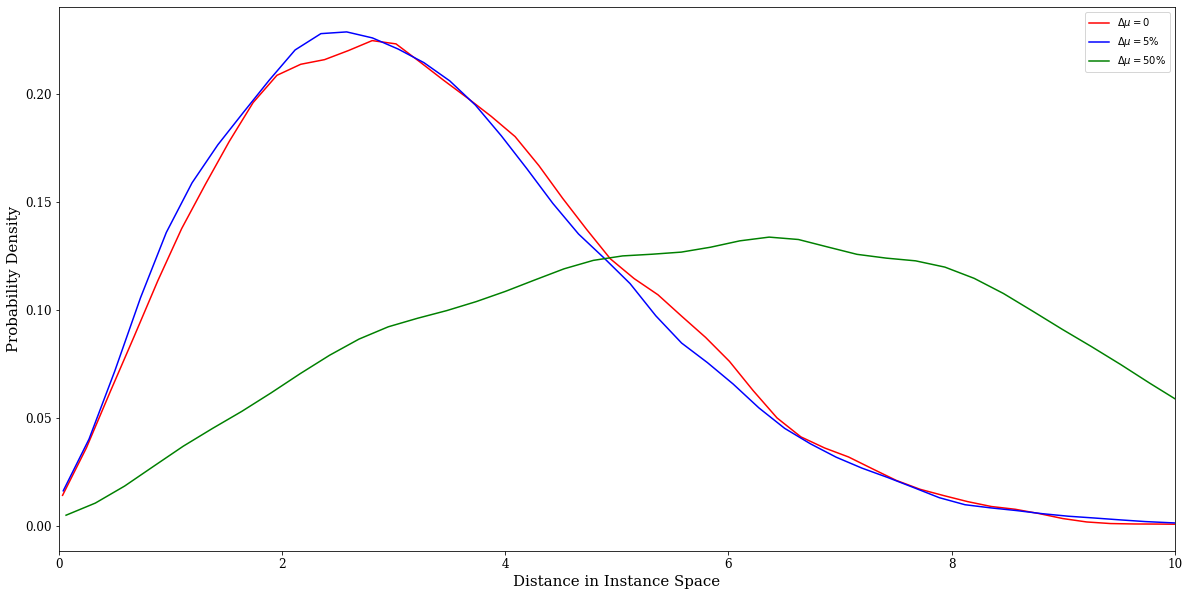

In [284]:
# compute pairwise distances, reshape and remove 0 entries
distances_same = embedding[:200] # mu = -1
distances_same = pairwise_distances(distances_same, metric='euclidean')
distances_same = distances_same.reshape(distances_same.shape[0]**2,)
distances_same = distances_same[distances_same != 0]
n_same, x_same = np.histogram(distances_same, density=True, bins=50)
density_same = stats.gaussian_kde(distances_same)

distances_close_neg = embedding[200:300] # within 5% of mu = -1
distances_close_centre = embedding[300:400] 
distances_close_pos = embedding[400:500] 
distances_close_1 = pairwise_distances(distances_close_neg, distances_close_centre, metric='euclidean')
distances_close_2 = pairwise_distances(distances_close_pos, distances_close_centre, metric='euclidean')
distances_close_1 = distances_close_1.reshape(distances_close_1.shape[0]**2,)
distances_close_2 = distances_close_2.reshape(distances_close_2.shape[0]**2,)
distances_close = np.concatenate((distances_close_1, distances_close_2))
distances_close = distances_close[distances_close != 0]
n_close, x_close = np.histogram(distances_close, density=True, bins=50)
density_close = stats.gaussian_kde(distances_close)

distances_far_neg = embedding[500:600] # mu = -1
distances_far_centre = embedding[600:700]
distances_far_pos = embedding[700:]

distances_far_1 = pairwise_distances(distances_far_neg, distances_far_centre, metric='euclidean')
distances_far_2 = pairwise_distances(distances_far_pos, distances_far_centre, metric='euclidean')
distances_far_1 = distances_far_1.reshape(distances_far_1.shape[0]**2,)
distances_far_2 = distances_far_2.reshape(distances_far_2.shape[0]**2,)
distances_far = np.concatenate((distances_far_1, distances_far_2))
distances_far = distances_far[distances_far != 0]
n_far, x_far = np.histogram(distances_far, density=True, bins=50)
density_far = stats.gaussian_kde(distances_far)

plt.figure(figsize=(20,10))
plt.plot(x_same, density_same(x_same), color='red', label='$\Delta \mu = 0$')
plt.plot(x_close, density_close(x_close), color='blue', label='$\Delta \mu = 5\%$')
plt.plot(x_far, density_far(x_far), color='green', label='$\Delta \mu = 50\%$')
plt.xlim(0,10)
plt.legend()
plt.xlabel('Distance in Instance Space', fontsize=15)
plt.ylabel('Probability Density', fontsize=15)
plt.show()
